Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [62]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [63]:

from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
ls "/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/"

Test/  Train/


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [65]:
# Defining the path for train and test images
## Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [66]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [67]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [68]:
## train dataset 
## Note using seed=123 while creating  dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, resizing  images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [69]:
## validation dataset here
## Note using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, your resizing  images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [70]:
# List of all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### creating a code to visualize one instance of all the nine classes present in the dataset

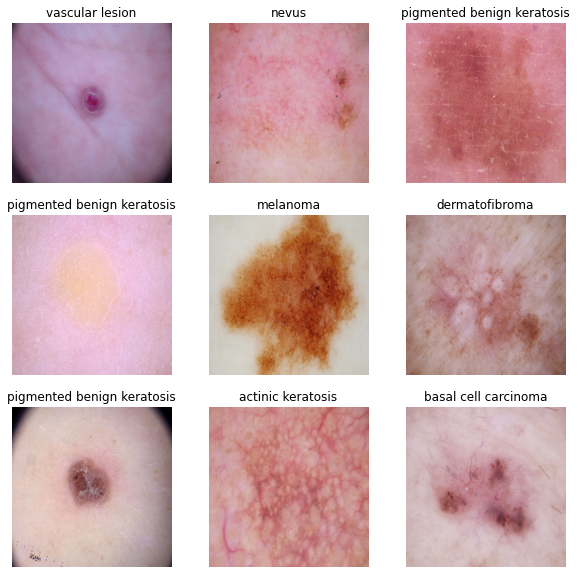

In [71]:
import matplotlib.pyplot as plt

num_classes = 9

class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [72]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [73]:
###  code goes here
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = "softmax")
])

### Compile the model
Choosing an appropirate optimiser and loss function for model training 

In [74]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])

In [75]:
# summary of all layers
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 32)      2432      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 32)        25632     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 45, 45, 64)        51264     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 22, 22, 64)      

### Train the model

In [76]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 21s 132ms/step - loss: 1.9747 - accuracy: 0.2768 - val_loss: 1.8386 - val_accuracy: 0.3244
Epoch 2/20
56/56 [==============================] - 4s 69ms/step - loss: 1.7324 - accuracy: 0.3800 - val_loss: 1.7623 - val_accuracy: 0.3736
Epoch 3/20
56/56 [==============================] - 4s 69ms/step - loss: 1.6513 - accuracy: 0.3973 - val_loss: 1.6444 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 4s 68ms/step - loss: 1.5950 - accuracy: 0.4224 - val_loss: 1.5454 - val_accuracy: 0.4765
Epoch 5/20
56/56 [==============================] - 4s 69ms/step - loss: 1.5020 - accuracy: 0.4860 - val_loss: 1.5266 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4616 - accuracy: 0.4883 - val_loss: 1.4534 - val_accuracy: 0.4899
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3700 - accuracy: 0.5246 - val_loss: 1.3883 - val_accuracy: 0.5213
Epoch 8/20


### Visualizing training results

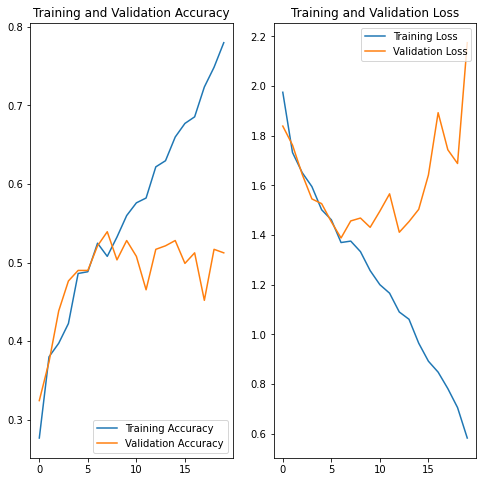

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

it is evident from the loss graph that model is overfitting


Traing accuracy for epoch 20 is at 78% and validation accuracy is at 51.2% this is clear case of overfitting






In [78]:
# after analysing the model fit history for presence of underfit or overfit, choosing an appropriate data augumentation strategy. 


data_augmentation = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])


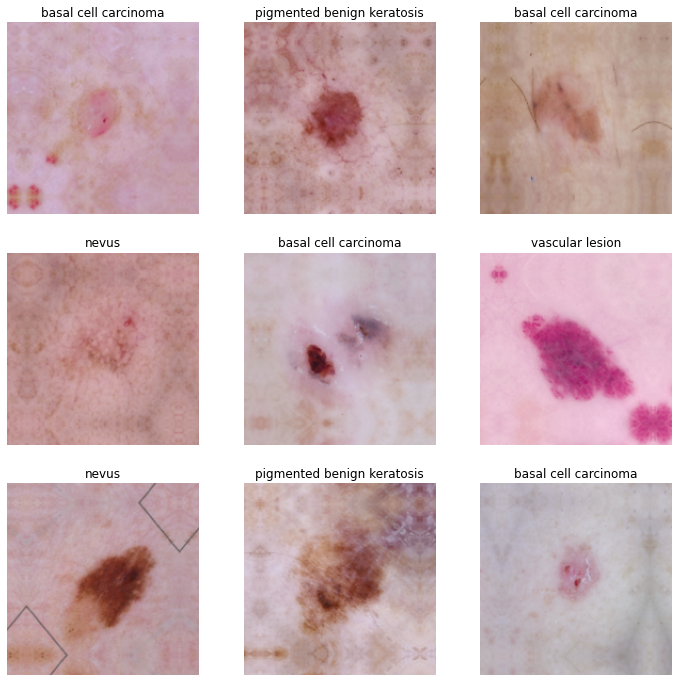

In [79]:
# visualizing how  augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Create the model, compile and train the model


In [80]:
## Using Dropout layer to see if there is an evidence of overfitting in your findings

## code goes here

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = "softmax")
])

### Compiling the model

In [81]:
## code goes here
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])
model.summary()



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 180, 180, 32)      2432      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 90, 90, 32)        25632     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 45, 45, 32)      

### Training the model

In [82]:
## code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 78ms/step - loss: 2.1225 - accuracy: 0.1970 - val_loss: 2.0737 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 74ms/step - loss: 2.0358 - accuracy: 0.2015 - val_loss: 2.0432 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 4s 73ms/step - loss: 2.0214 - accuracy: 0.2165 - val_loss: 2.0513 - val_accuracy: 0.1946
Epoch 4/20
56/56 [==============================] - 4s 74ms/step - loss: 2.0056 - accuracy: 0.2662 - val_loss: 1.9947 - val_accuracy: 0.2416
Epoch 5/20
56/56 [==============================] - 4s 73ms/step - loss: 1.7857 - accuracy: 0.3677 - val_loss: 1.6282 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 4s 73ms/step - loss: 1.6201 - accuracy: 0.4180 - val_loss: 1.5162 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 4s 73ms/step - loss: 1.5247 - accuracy: 0.4676 - val_loss: 1.6317 - val_accuracy: 0.4340
Epoch 8/20
56

### Visualizing the results

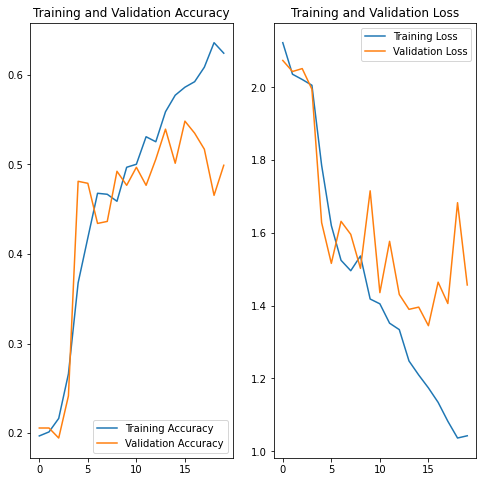

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**There improvements in accuracy from the base model, but some improvement w.r.t loss and hence overfitting is  handled due to dropouts**



#### Finding the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [84]:
## code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df
original_df.count

<bound method DataFrame.count of                                                    Path              Label
0     /content/drive/MyDrive/Colab Notebooks/Skin ca...  actinic keratosis
1     /content/drive/MyDrive/Colab Notebooks/Skin ca...  actinic keratosis
2     /content/drive/MyDrive/Colab Notebooks/Skin ca...  actinic keratosis
3     /content/drive/MyDrive/Colab Notebooks/Skin ca...  actinic keratosis
4     /content/drive/MyDrive/Colab Notebooks/Skin ca...  actinic keratosis
...                                                 ...                ...
2234  /content/drive/MyDrive/Colab Notebooks/Skin ca...    vascular lesion
2235  /content/drive/MyDrive/Colab Notebooks/Skin ca...    vascular lesion
2236  /content/drive/MyDrive/Colab Notebooks/Skin ca...    vascular lesion
2237  /content/drive/MyDrive/Colab Notebooks/Skin ca...    vascular lesion
2238  /content/drive/MyDrive/Colab Notebooks/Skin ca...    vascular lesion

[2239 rows x 2 columns]>

<BarContainer object of 9 artists>

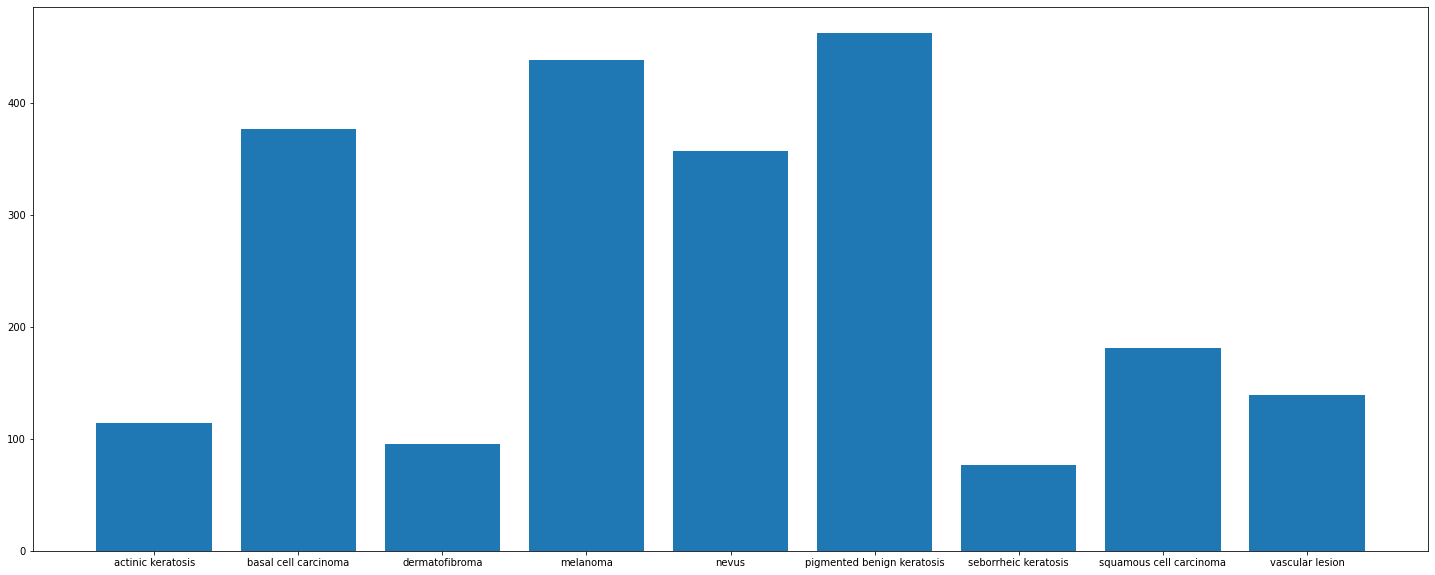

In [85]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
count 
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### My findings here: 
#### - Which class has the least number of samples?
Answer - Seborrheic Keratosis has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
Answer - Pigmented benign Keratosis dominates the data


####  Rectifying the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [86]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [88]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7762AB9190>: 100%|██████████| 500/500 [00:22<00:00, 22.46 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F776033ED10>: 100%|██████████| 500/500 [00:22<00:00, 22.01 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F776033ED90>: 100%|██████████| 500/500 [00:23<00:00, 21.56 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7F7764559290>: 100%|██████████| 500/500 [01:42<00:00,  4.88 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F77628E4150>: 100%|██████████| 500/500 [01:33<00:00,  5.37 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F76EAA91B50>: 100%|██████████| 500/500 [00:23<00:00, 21.14 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F776296C250>: 100%|██████████| 500/500 [00:48<00:00, 10.21 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F76EA744350>: 100%|██████████| 500/500 [00:23<00:00, 21.05 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F76EAAC6ED0>: 100%|██████████| 500/500 [00:23<00:00, 21.03 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [89]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [91]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010485.jpg_989c92fa-37e0-464e-98c8-7ba69df9a7f3.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009890.jpg_3141c3cd-f3b7-45ba-9f5b-fdee5a458874.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010630.jpg_8fcd5a9c-3eeb-4fca-8836-bb5d0d305cd1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000156.jpg_c1c62230-97a8-4c99-bef2-be0dc8a703c6.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011040.jpg_8c4bf14c-04d7-4494-8c07-a329

In [92]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [94]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [95]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [96]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

####  Training the model on the data created using Augmentor

In [97]:
batch_size = 32
img_height = 180
img_width = 180

####  Creating a training dataset

In [98]:
# data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train=pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [99]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating your model (make sure to include normalization)

In [102]:
## code goes here
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 5, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 5, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation = "softmax")
])

####  Compiling the model (with appropriaye optimizer and loss function )

In [103]:
## code goes here
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_11 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 180, 180, 32)      2432      
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 90, 90, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 32)      

####  Training the model

In [104]:
epochs = 30
## code goes here, use 30 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 43s 241ms/step - loss: 3.3563 - accuracy: 0.2893 - val_loss: 7.5342 - val_accuracy: 0.1455
Epoch 2/30
169/169 [==============================] - 41s 235ms/step - loss: 1.6401 - accuracy: 0.4123 - val_loss: 4.6640 - val_accuracy: 0.2524
Epoch 3/30
169/169 [==============================] - 41s 235ms/step - loss: 1.4409 - accuracy: 0.4581 - val_loss: 3.4193 - val_accuracy: 0.3586
Epoch 4/30
169/169 [==============================] - 41s 236ms/step - loss: 1.2994 - accuracy: 0.5015 - val_loss: 2.2553 - val_accuracy: 0.3081
Epoch 5/30
169/169 [==============================] - 41s 238ms/step - loss: 1.1738 - accuracy: 0.5555 - val_loss: 2.1644 - val_accuracy: 0.3638
Epoch 6/30
169/169 [==============================] - 41s 237ms/step - loss: 1.1009 - accuracy: 0.5695 - val_loss: 1.8572 - val_accuracy: 0.4224
Epoch 7/30
169/169 [==============================] - 41s 238ms/step - loss: 0.9593 - accuracy: 0.6256 - val_loss: 1.1703 - val_ac

####   Visualizing the model results

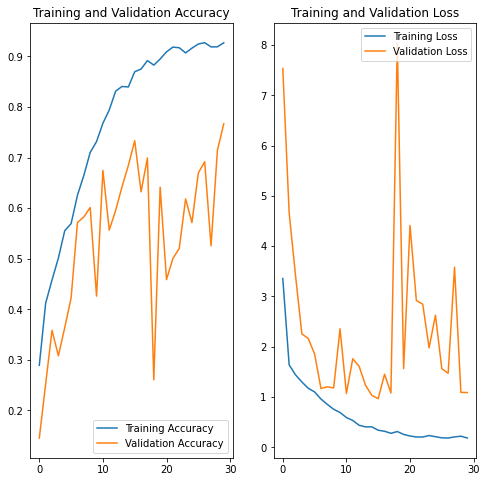

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Analysis of results here. Did it get rid of underfitting/overfitting? Did class rebalance help?
Analysis -
- Accuracy of training and validation data is looking good , 92.7% for training and 77% for validation 
- Overfitting issue is resolved as loss gap between training and validation is signifiantly reduded however there is one outlier at epoch 19

Class rebalance using augmentor and batch normalization has done good job here.
